In [1]:
from Functions2 import *
from DataDefined2 import *
from Functions import *
from DataDefined import *
import numpy as np

df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

# Out-of-distribution class
CLASS_OOD = 1

In [2]:
# Dropping columns
columns_to_drop = one_val_col + irrelevant_col
df = df.drop(columns_to_drop, axis=1)

# Adding columns
df = addRideNumbers(df)

In [3]:
for driver_class in sorted(df['Class'].unique()):
    driver_data = df[df['Class'] == driver_class]
    ride_counts = driver_data['Ride number'].unique()
    print(f"Ride number for Class {driver_class}: {ride_counts}")

Ride number for Class A: [0 1 2 3]
Ride number for Class B: [0 1 2 3 4 5]
Ride number for Class C: [0 1 2 3]
Ride number for Class D: [0 1 2 3 4 5]
Ride number for Class E: [0 1 2 3]
Ride number for Class F: [0 1 2 3]
Ride number for Class G: [0 1 2 3]
Ride number for Class H: [0 1 2 3]
Ride number for Class I: [0 1 2 3]
Ride number for Class J: [0 1 2 3]


In [4]:
# Encode the class first, as this cannot be encoded after the train-test-split, due to being out-of-distribution
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

train_df, test_df = split_train_test_ood(df, CLASS_OOD, frac=0.15)

# Normalize
columns_to_scale = numerical_col + two_val_col
train_df, test_df = normalize_data(train_df, test_df, columns_to_scale)
# Encode
train_df, test_df = label_encode(train_df, test_df, categorical_col)

print("Classes in train:", len(train_df['Class'].unique()))
print("Classes in test:", len(test_df['Class'].unique()))

Classes in train: 9
Classes in test: 10


In [5]:
# Convert to input for the model
X_train = torch.tensor(train_df[numerical_col + ['Indication_of_brake_switch_ON/OFF']].values, dtype=torch.float32)
X_test = torch.tensor(test_df[numerical_col + ['Indication_of_brake_switch_ON/OFF']].values, dtype=torch.float32)

y_train = torch.tensor(train_df['Class'].values, dtype=torch.long)
y_test = torch.tensor(test_df['Class'].values, dtype=torch.long)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(y_test == CLASS_OOD, -1, y_test)

torch.Size([69288, 35])
torch.Size([25092, 35])
torch.Size([69288])
torch.Size([25092])


In [6]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500

In [7]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.65  
    predicted_classes[max_probs < threshold] = -1 

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (69288x128 and 92x64)

In [8]:
from sklearn import metrics
def calculate_ROC_AUC_score(y_test_ood, max_probs):
    """
    Calculates the ROC AUC score for a model based on its probability predictions 
    and the actual class labels (in or out of distribution).

    @param y_test_ood   tensor containing the actual class labels, where -1 represents out-of-distribution
    @param max_probs    tensor or array containing the model's probability predictions
    
    @return roc_auc_score_of_model  computed ROC AUC score as a float
    """
    # Convert OOD (-1) labels to 0, and in-distribution labels to 1
    x_true_values = torch.where(y_test_ood == -1, torch.tensor(0), torch.tensor(1))

    # Compute the ROC AUC score
    roc_auc_score_of_model = metrics.roc_auc_score(x_true_values.numpy(), max_probs.numpy())

    return roc_auc_score_of_model

In [9]:
calculate_ROC_AUC_score(y_test_ood,max_probs)

0.5685895610880827

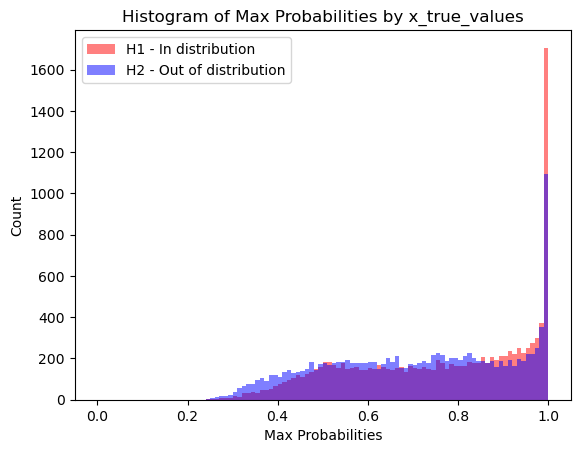

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x_true_values= torch.where(y_test_ood == -1, torch.tensor(0), torch.tensor(1))
# Separate max_probs based on x_true_values
max_probs_0 = max_probs[x_true_values == 0]
max_probs_1 = max_probs[x_true_values == 1]

bins = np.arange(0, 1.01, 0.01)

plt.hist(max_probs_1, bins=bins, alpha=0.5, color='red', label='H1 - In distribution')
plt.hist(max_probs_0, bins=bins, alpha=0.5, color='blue', label='H2 - Out of distribution')

plt.xlabel('Max Probabilities')
plt.ylabel('Count')
plt.title('Histogram of Max Probabilities by x_true_values')
plt.legend()

plt.show()


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_ood, predicted_classes)
print(cm)

[[5052   18  216 3405  685  115  143 1140  809 1281]
 [  67 1009    4    0    0    0    4    0    0    2]
 [ 312    0  754   27    0   23    3    4    0    2]
 [ 547    0   24 1352    5   28   16   14    0    1]
 [  23    0    2    2 1238    0    0    0    0    0]
 [ 419    1    7   24    2 1171   10   14    0    4]
 [ 408    9    3   33    0   13  628   14   15    1]
 [ 687    1    2    5    2   28    2  702   21   32]
 [ 702    1    5    0    0    0    6   53  365   39]
 [ 788    1    5    6    7   10    1   33   20  465]]


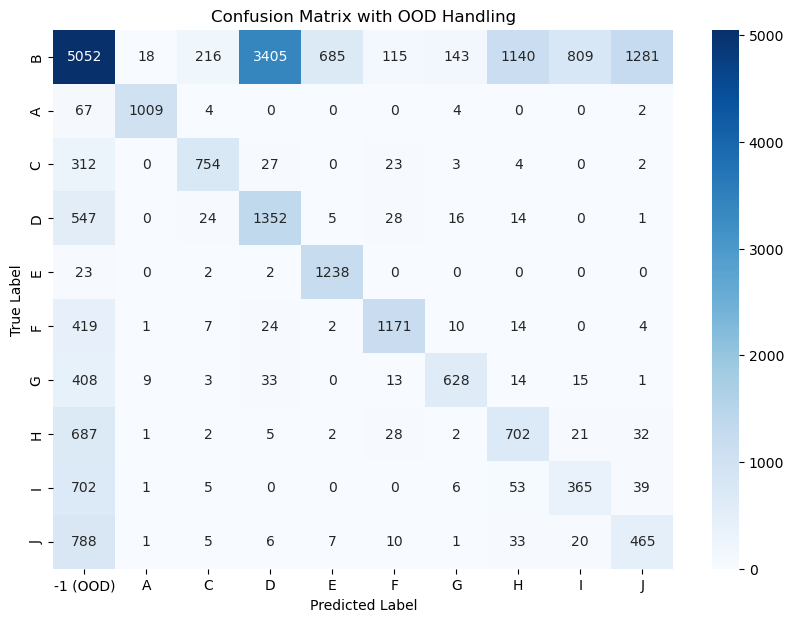

In [12]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= ['-1 (OOD)',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'], 
            yticklabels= ['B',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix with OOD Handling')
plt.show()

In [13]:
print(classification_report(y_test_ood, predicted_classes))

              precision    recall  f1-score   support

          -1       0.56      0.39      0.46     12864
           0       0.97      0.93      0.95      1086
           2       0.74      0.67      0.70      1125
           3       0.28      0.68      0.40      1987
           4       0.64      0.98      0.77      1265
           5       0.84      0.71      0.77      1652
           6       0.77      0.56      0.65      1124
           7       0.36      0.47      0.41      1482
           8       0.30      0.31      0.30      1171
           9       0.25      0.35      0.29      1336

    accuracy                           0.51     25092
   macro avg       0.57      0.61      0.57     25092
weighted avg       0.56      0.51      0.51     25092



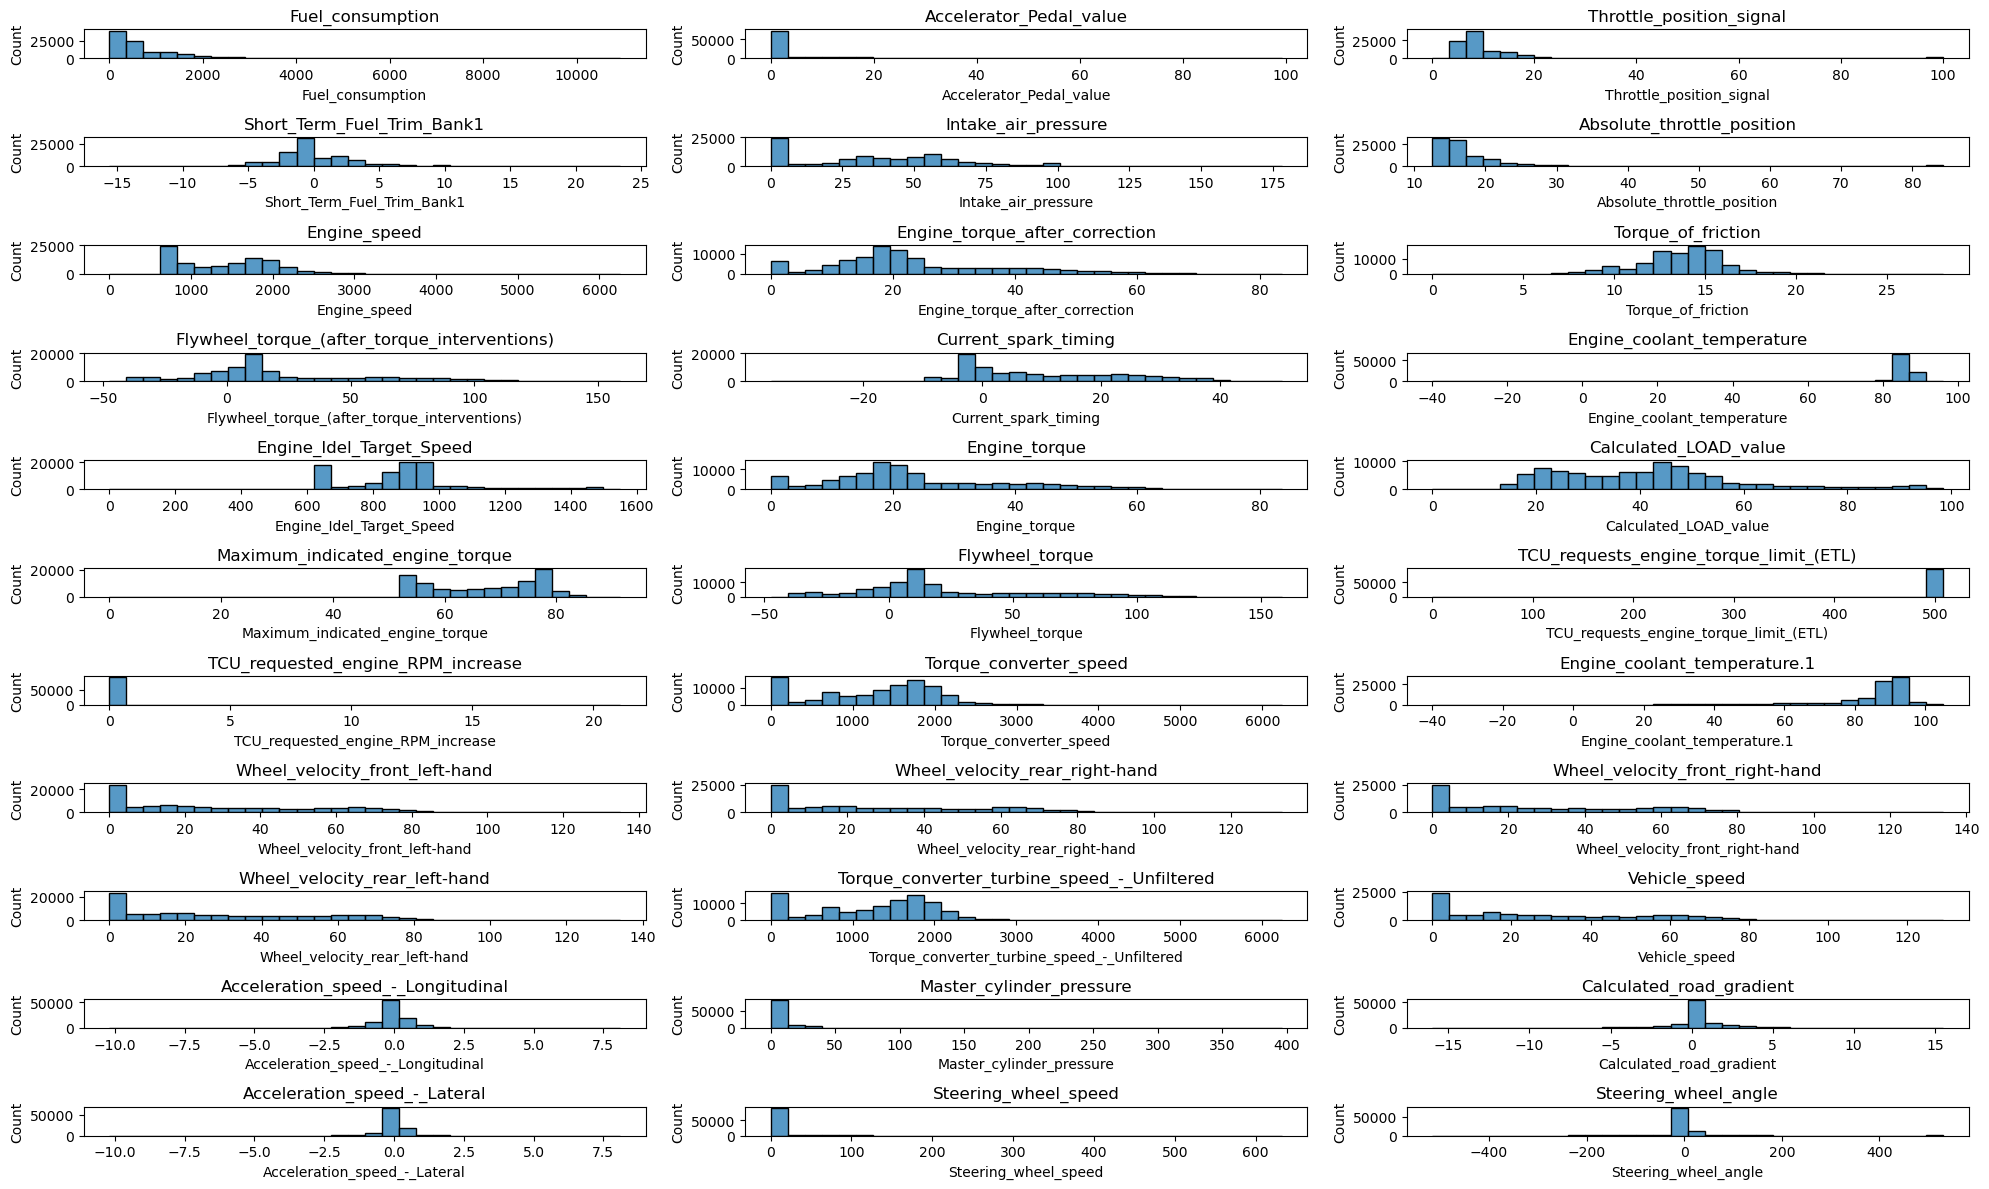

In [14]:
from Functions2 import *
from DataDefined2 import *
from Functions import *
from DataDefined import *
import numpy as np

df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

# Out-of-distribution class
CLASS_OOD = 1

df, label_mappings = preprocessing(df, one_val_col, to_be_scaled_col, two_val_col, some_val_num_col, some_val_cat_col)


In [15]:
train_drivers=['B']
test_drivers=['D']

relevant_features = [
    'Current_Gear', 
    'Converter_clutch', 
    'Gear_Selection', 
    'Indication_of_brake_switch_ON/OFF',
    'Fuel_consumption', 
    'Accelerator_Pedal_value', 
    'Throttle_position_signal', 
    'Short_Term_Fuel_Trim_Bank1', 
    'Intake_air_pressure', 
    'Absolute_throttle_position', 
    'Engine_speed', 
    'Torque_of_friction', 
    'Flywheel_torque_(after_torque_interventions)', 
    'Current_spark_timing', 
    'Engine_coolant_temperature', 
    'Engine_Idel_Target_Speed', 
    'Engine_torque', 
    'Calculated_LOAD_value', 
    'Maximum_indicated_engine_torque', 
    'Flywheel_torque', 
    'TCU_requests_engine_torque_limit_(ETL)', 
    'TCU_requested_engine_RPM_increase', 
    'Torque_converter_speed', 
    'Engine_coolant_temperature.1', 
    'Wheel_velocity_front_left-hand', 
    'Wheel_velocity_rear_right-hand', 
    'Wheel_velocity_front_right-hand', 
    'Wheel_velocity_rear_left-hand', 
    'Torque_converter_turbine_speed_-_Unfiltered', 
    'Vehicle_speed', 
    'Acceleration_speed_-_Longitudinal', 
    'Master_cylinder_pressure', 
    'Calculated_road_gradient', 
    'Acceleration_speed_-_Lateral', 
    'Steering_wheel_speed', 
    'Steering_wheel_angle',
    'Long_Term_Fuel_Trim_Bank1', 
    'Minimum_indicated_engine_torque',
    'Engine_in_fuel_cut_off', 
    'Standard_Torque_Ratio', 
    'Requested_spark_retard_angle_from_TCU', 
    'Target_engine_speed_used_in_lock-up_module', 
    'Activation_of_Air_compressor', 
    'Clutch_operation_acknowledge'
]


X_train, X_test, y_train, y_test = smart_split_train(df, relevant_features, 1, train_drivers, test_drivers)

mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 
           'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}
y_train = y_train.map(mapping)
y_test = y_test.map(mapping)

mapping = np.vectorize(lambda x: ord(x) - ord('A'))  # Converts 'A' -> 0, 'B' -> 1, ..., 'I' -> 8
train_drivers = mapping(train_drivers)

# Convert to input for the model
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(~torch.isin(y_test, torch.tensor(train_drivers)), -1, y_test)

In [16]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.65  
    predicted_classes[max_probs < threshold] = -1 

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)

Epoch 0, Loss: 2.2936
Epoch 10, Loss: 1.9218
Epoch 20, Loss: 1.3530
Epoch 30, Loss: 0.6063
Epoch 40, Loss: 0.1412
Epoch 50, Loss: 0.0303
Epoch 60, Loss: 0.0104
Epoch 70, Loss: 0.0056
Epoch 80, Loss: 0.0039
Epoch 90, Loss: 0.0031
Epoch 100, Loss: 0.0026
Epoch 110, Loss: 0.0023
Epoch 120, Loss: 0.0020
Epoch 130, Loss: 0.0018
Epoch 140, Loss: 0.0016
Epoch 150, Loss: 0.0015
Epoch 160, Loss: 0.0013
Epoch 170, Loss: 0.0012
Epoch 180, Loss: 0.0011
Epoch 190, Loss: 0.0010
Epoch 200, Loss: 0.0009
Epoch 210, Loss: 0.0008
Epoch 220, Loss: 0.0008
Epoch 230, Loss: 0.0007
Epoch 240, Loss: 0.0007
Epoch 250, Loss: 0.0006
Epoch 260, Loss: 0.0006
Epoch 270, Loss: 0.0005
Epoch 280, Loss: 0.0005
Epoch 290, Loss: 0.0005
Epoch 300, Loss: 0.0005
Epoch 310, Loss: 0.0004
Epoch 320, Loss: 0.0004
Epoch 330, Loss: 0.0004
Epoch 340, Loss: 0.0004
Epoch 350, Loss: 0.0003
Epoch 360, Loss: 0.0003
Epoch 370, Loss: 0.0003
Epoch 380, Loss: 0.0003
Epoch 390, Loss: 0.0003
Epoch 400, Loss: 0.0003
Epoch 410, Loss: 0.0003
Epo

In [17]:
def calculate_ROC_AUC_score(y_test_ood, max_probs):
    """
    Calculates the ROC AUC score for a model based on its probability predictions 
    and the actual class labels (in or out of distribution).

    @param y_test_ood   tensor containing the actual class labels, where -1 represents out-of-distribution
    @param max_probs    tensor or array containing the model's probability predictions
    
    @return roc_auc_score_of_model  computed ROC AUC score as a float
    """
    # Convert OOD (-1) labels to 0, and in-distribution labels to 1
    x_true_values = torch.where(y_test_ood == -1, torch.tensor(0), torch.tensor(1))

    # Compute the ROC AUC score
    roc_auc_score_of_model = metrics.roc_auc_score(x_true_values.numpy(), max_probs.numpy())

    return roc_auc_score_of_model

calculate_ROC_AUC_score(y_test_ood,max_probs)

0.3830503948900804

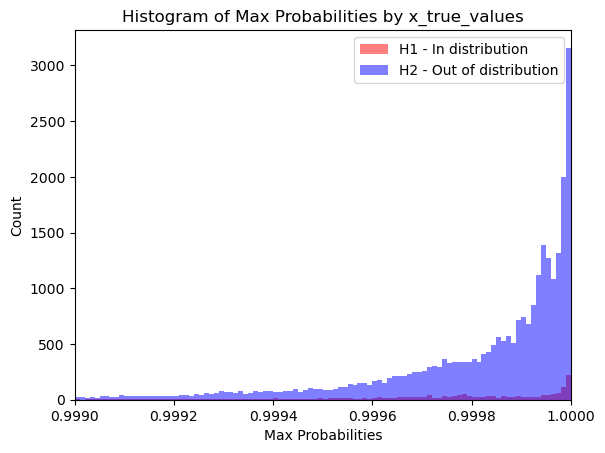

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x_true_values= torch.where(y_test_ood == -1, torch.tensor(0), torch.tensor(1))
# Separate max_probs based on x_true_values
max_probs_0 = max_probs[x_true_values == 0]
max_probs_1 = max_probs[x_true_values == 1]

bins = np.arange(0.999, 1.00001, 0.00001)

plt.hist(max_probs_1, bins=bins, alpha=0.5, color='red', label='H1 - In distribution')
plt.hist(max_probs_0, bins=bins, alpha=0.5, color='blue', label='H2 - Out of distribution')

plt.xlabel('Max Probabilities')
plt.ylabel('Count')
plt.title('Histogram of Max Probabilities by x_true_values')
plt.xlim(0.999,1)
plt.legend()

plt.show()